In [192]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

In [233]:
# Read the CSVs into a variable
price_data = pd.read_csv('hotels-europe_price.csv')
features_data = pd.read_csv('hotels-europe_features.csv')

In [234]:
# merge the two datasets with the key 'hotel_id'
merged_hotel_data = pd.merge(price_data, features_data, on='hotel_id')

In [235]:
# convert accommodation_type and city_actual to string so that it can be filtered
merged_hotel_data['accommodation_type'] = merged_hotel_data['accommodation_type'].astype('string')
merged_hotel_data['city_actual']=merged_hotel_data['city'].astype('string')

In [236]:
# Dropping duplicates after merging
# merged_hotel_data = merged_hotel_data.drop_duplicates(subset='hotel_id')

In [237]:
# filter the merged data for Moscow
merged_hotel_data_moscow = merged_hotel_data.loc[(merged_hotel_data["city"].isin(['Moscow']))
                                                  ]
merged_hotel_data_moscow

,hotel_id,price,offer,offer_cat,year,month,weekend,holiday,nnights,scarce_room,...,country,city_actual,rating_reviewcount,center1label,center2label,neighbourhood,ratingta,ratingta_count,distance_alter,accommodation_type
77569,10946,16,0,0% no offer,2018,3,1,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Akademicheskiy,4.0,1.0,7.8,Hostel
77570,10946,16,0,0% no offer,2017,12,0,1,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Akademicheskiy,4.0,1.0,7.8,Hostel
77571,10946,16,0,0% no offer,2018,5,1,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Akademicheskiy,4.0,1.0,7.8,Hostel
77572,10946,17,0,0% no offer,2017,11,0,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Akademicheskiy,4.0,1.0,7.8,Hostel
77573,10946,64,0,0% no offer,2017,12,0,1,4,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Akademicheskiy,4.0,1.0,7.8,Hostel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80922,11345,43,0,0% no offer,2018,4,1,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Yudino,NaN,NaN,8.6,Hotel
80923,11345,43,0,0% no offer,2018,2,1,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Yudino,NaN,NaN,8.6,Hotel
80924,11345,43,0,0% no offer,2018,1,1,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Yudino,NaN,NaN,8.6,Hotel
80925,11345,43,0,0% no offer,2018,3,1,0,1,1,...,Russia,Moscow,NaN,City centre,Solntsevo Exhibition Hall,Yudino,NaN,NaN,8.6,Hotel


### Ratings Data Cleaning

In [238]:
# Step 1: Identify the number of null values in the 'rating' column
null_count = merged_hotel_data_moscow['rating'].isnull().sum()
print(f"Number of null values in the 'rating' column: {null_count}")

Number of null values in the 'rating' column: 792


In [239]:
# Step 2: Transform null values to 0
merged_hotel_data_moscow['rating'].fillna('NULL', inplace=True)

In [240]:
# Optionally, verify the transformation
print(merged_hotel_data_moscow['rating'].isnull().sum())  # Should output 0

0


In [242]:
# Drop rows where 'rating_reviewcount' is 'NULL'
merged_hotel_data_moscow = merged_hotel_data_moscow[merged_hotel_data_moscow['rating'] != 'NULL']

# Optionally, verify the operation
print(f"Number of rows with 'rating' as 'NULL': {len(merged_hotel_data_moscow[merged_hotel_data_moscow['rating'] == 'NULL'])}")

Number of rows with 'rating' as 'NULL': 0


### `rating_reviewcount` cleaning

In [243]:
# Step 1: Identify the number of null values in the 'rating' column
null_count = merged_hotel_data_moscow['rating_reviewcount'].isnull().sum()
print(f"Number of null values in the 'rating' column: {null_count}")

Number of null values in the 'rating' column: 0


In [244]:
# Step 2: Transform null values to 0
merged_hotel_data_moscow['rating_reviewcount'].fillna('NULL', inplace=True)

In [245]:
# Optionally, verify the transformation
print(merged_hotel_data_moscow['rating_reviewcount'].isnull().sum())  # Should output 0

0


In [246]:
# Drop rows where 'rating_reviewcount' is 'NULL'
merged_hotel_data_moscow = merged_hotel_data_moscow[merged_hotel_data_moscow['rating_reviewcount'] != 'NULL']

# Optionally, verify the operation
print(f"Number of rows with 'rating_reviewcount' as 'NULL': {len(merged_hotel_data_moscow[merged_hotel_data_moscow['rating_reviewcount'] == 'NULL'])}")

Number of rows with 'rating_reviewcount' as 'NULL': 0


### Create `highly_rated` column

In [247]:
# new column 'highly_rated'
# Set to 1 if 'rating' is greater than or equal to 4, and 0 otherwise
merged_hotel_data_moscow['highly_rated'] = merged_hotel_data_moscow['rating'].apply(lambda x: 1 if x >= 4 else 0)
print(merged_hotel_data_moscow.head())

       hotel_id  price  offer     offer_cat  year  month  weekend  holiday  \
77578     10947     59      1  15-50% offer  2017     12        0        1   
77579     10947     58      1  15-50% offer  2018      4        1        0   
77580     10947     58      1  15-50% offer  2018      5        1        0   
77581     10947    231      1  15-50% offer  2017     12        0        1   
77582     10947     81      0   0% no offer  2017     11        0        0   

       nnights  scarce_room  ... city_actual  rating_reviewcount  \
77578        1            0  ...      Moscow               240.0   
77579        1            0  ...      Moscow               240.0   
77580        1            0  ...      Moscow               240.0   
77581        4            0  ...      Moscow               240.0   
77582        1            0  ...      Moscow               240.0   

       center1label               center2label neighbourhood ratingta  \
77578   City centre  Solntsevo Exhibition Hall   

In [278]:
merged_hotel_data_moscow

,hotel_id,price,offer,offer_cat,year,month,weekend,holiday,nnights,scarce_room,...,center1label,center2label,neighbourhood,ratingta,ratingta_count,distance_alter,accommodation_type,highly_rated,distance_category,rating_reviewcount_category
77578,10947,59,1,15-50% offer,2017,12,0,1,1,0,...,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0,5-6,501+
77579,10947,58,1,15-50% offer,2018,4,1,0,1,0,...,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0,5-6,501+
77580,10947,58,1,15-50% offer,2018,5,1,0,1,0,...,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0,5-6,501+
77581,10947,231,1,15-50% offer,2017,12,0,1,4,0,...,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0,5-6,501+
77582,10947,81,0,0% no offer,2017,11,0,0,1,0,...,City centre,Solntsevo Exhibition Hall,Alexeevsky,3.0,2351.0,15.0,Hotel,0,5-6,501+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80903,11343,339,0,0% no offer,2017,12,0,1,4,0,...,City centre,Solntsevo Exhibition Hall,Yakimanka,3.5,146.0,9.9,Hotel,0,3-4,7-17
80904,11343,60,0,0% no offer,2018,1,1,0,1,0,...,City centre,Solntsevo Exhibition Hall,Yakimanka,3.5,146.0,9.9,Hotel,0,3-4,7-17
80905,11343,60,0,0% no offer,2017,11,1,0,1,1,...,City centre,Solntsevo Exhibition Hall,Yakimanka,3.5,146.0,9.9,Hotel,0,3-4,7-17
80906,11343,60,0,0% no offer,2017,12,0,1,1,1,...,City centre,Solntsevo Exhibition Hall,Yakimanka,3.5,146.0,9.9,Hotel,0,3-4,7-17


In [249]:
# Assuming 'merged_hotel_data' is your DataFrame
# Selecting some potential independent variables (adjust as needed)
X = merged_hotel_data_moscow[['price', 'nnights', 'stars', 'rating_reviewcount', 'distance', 'holiday', 'offer']]  # Example features
y = merged_hotel_data_moscow['highly_rated']  # Dependent variable

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Building the OLS model
model = sm.OLS(y, X).fit()

# Printing the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           highly_rated   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     56.72
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           8.53e-76
Time:                        16:58:50   Log-Likelihood:                -1547.5
No. Observations:                2566   AIC:                             3111.
Df Residuals:                    2558   BIC:                             3158.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1371      0

# Distribution Analysis

In [265]:
# Determine best number of bins using Sturges' Rule
num_bins_price = int(1 + np.log2(len(merged_hotel_data_moscow['price'])))
print(f"Optimal number of bins for 'price': {num_bins_price}")

Optimal number of bins for 'price': 12


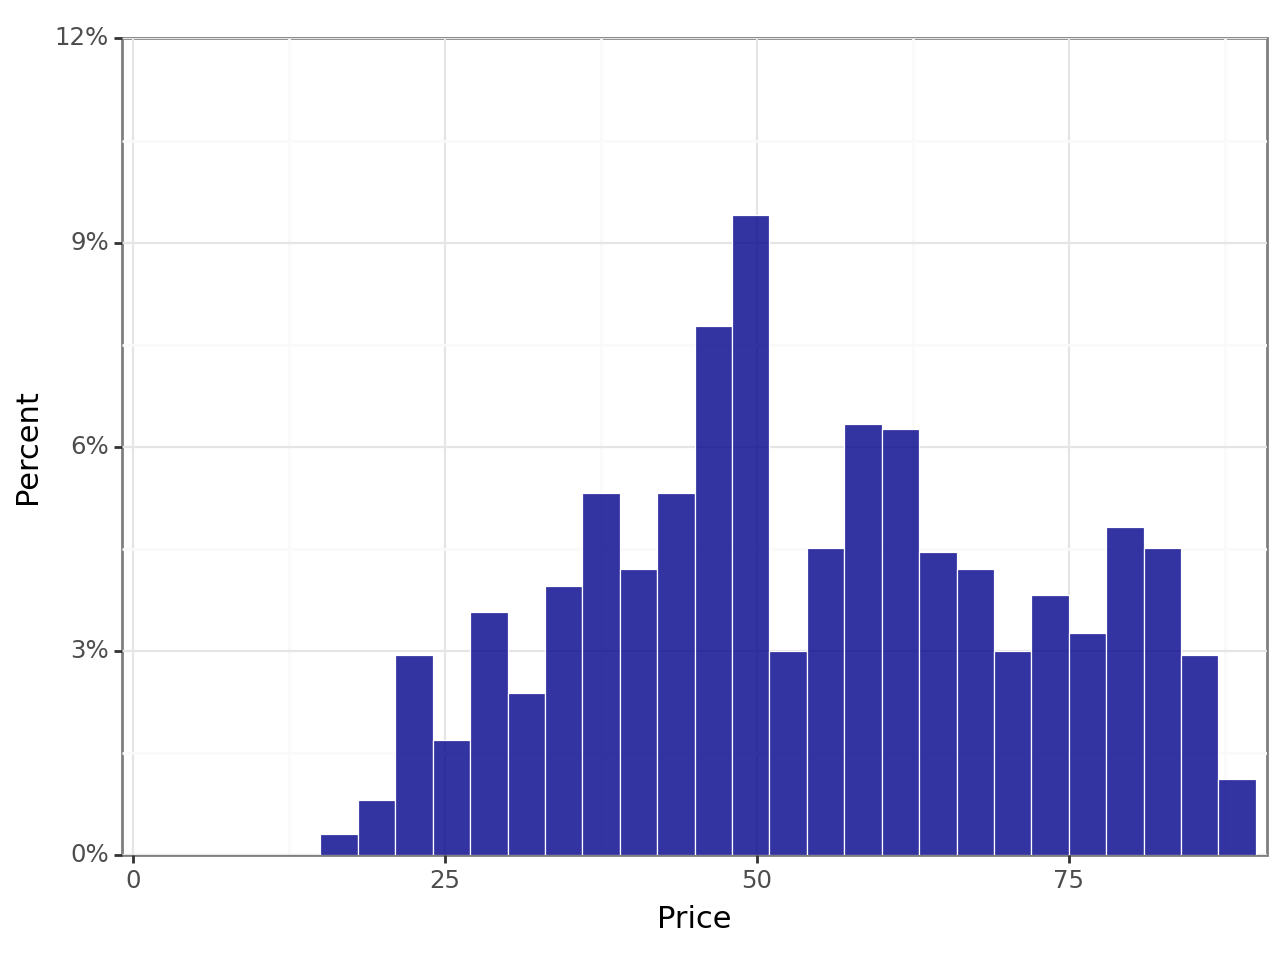

<Figure Size: (640 x 480)>

In [267]:
# price distribution
(
    ggplot(merged_hotel_data_moscow, aes(x="price", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Price", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 90))
    + scale_y_continuous(
        labels=percent_format(), #mizani
        limits=(0, 0.12),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)

In [263]:
# Determine best number of bins using Sturges' Rule
num_bins_stars = int(1 + np.log2(len(merged_hotel_data_moscow['stars'])))
print(f"Optimal number of bins for 'stars': {num_bins_stars}")

Optimal number of bins for 'stars': 12


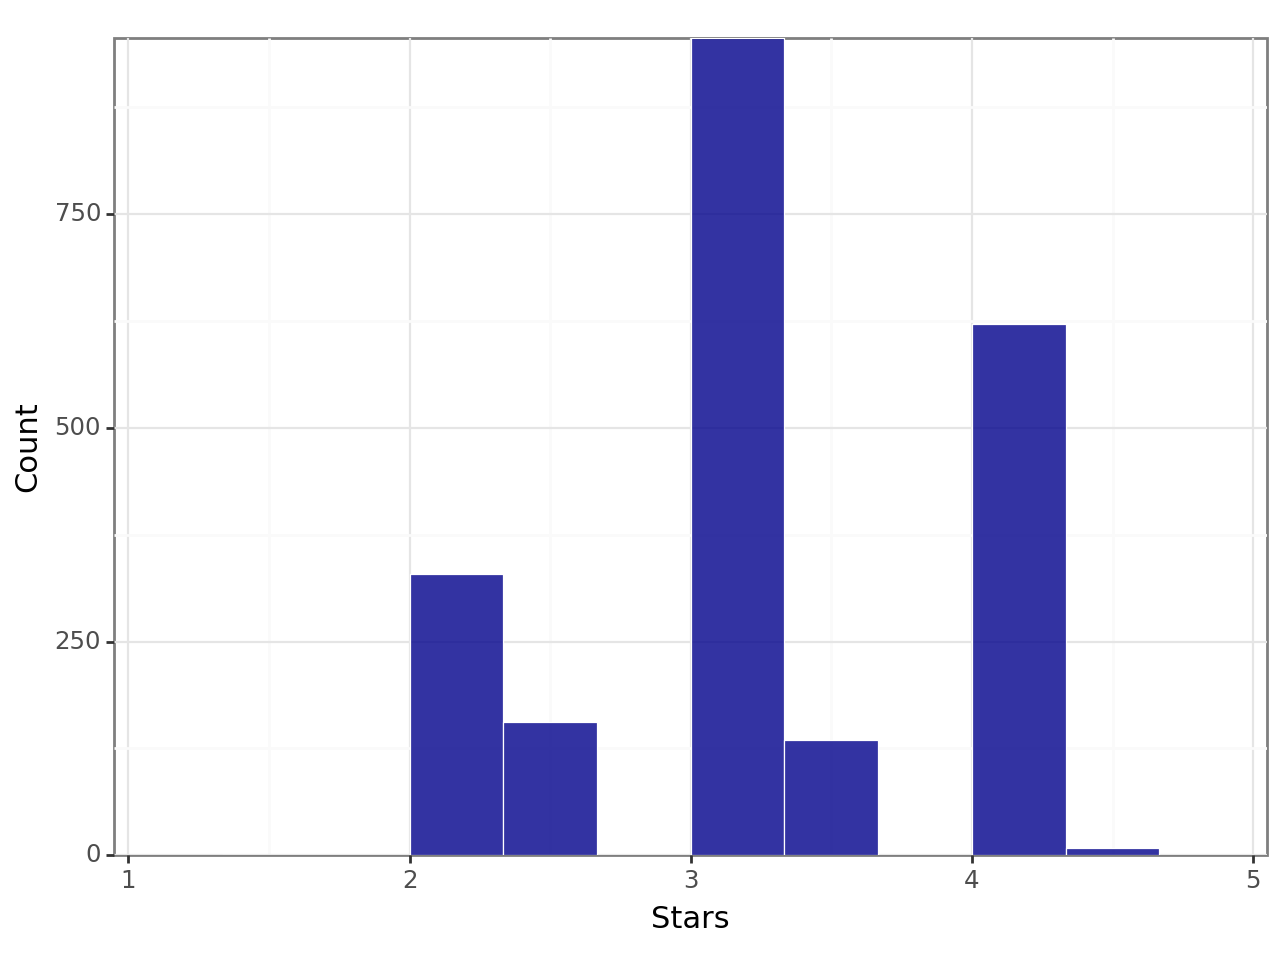

<Figure Size: (640 x 480)>

In [264]:
# stars distribution

# Calculate range of 'rating_reviewcount' data
data_range_stars = merged_hotel_data_moscow['stars'].max() - merged_hotel_data_moscow['stars'].min()

# Calculate binwidth for 12 bins
binwidth_stars = data_range_stars / 12

(
    ggplot(merged_hotel_data_moscow, aes(x="stars", y="..count.."))  # Use ..count.. for actual counts
    + geom_histogram(
        binwidth=binwidth_stars,
        boundary=0,
        color="white",
        fill="darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Stars", y="Count")  # Update label to "Count"
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        # Adjust limits based on the range of your count data
    )
    + theme_bw()
)


### Distance Distribution

In [260]:
# Determine best number of bins using Sturges' Rule
num_bins_distance = int(1 + np.log2(len(merged_hotel_data_moscow['distance'])))
print(f"Optimal number of bins for 'distance': {num_bins_distance}")

Optimal number of bins for 'distance': 12


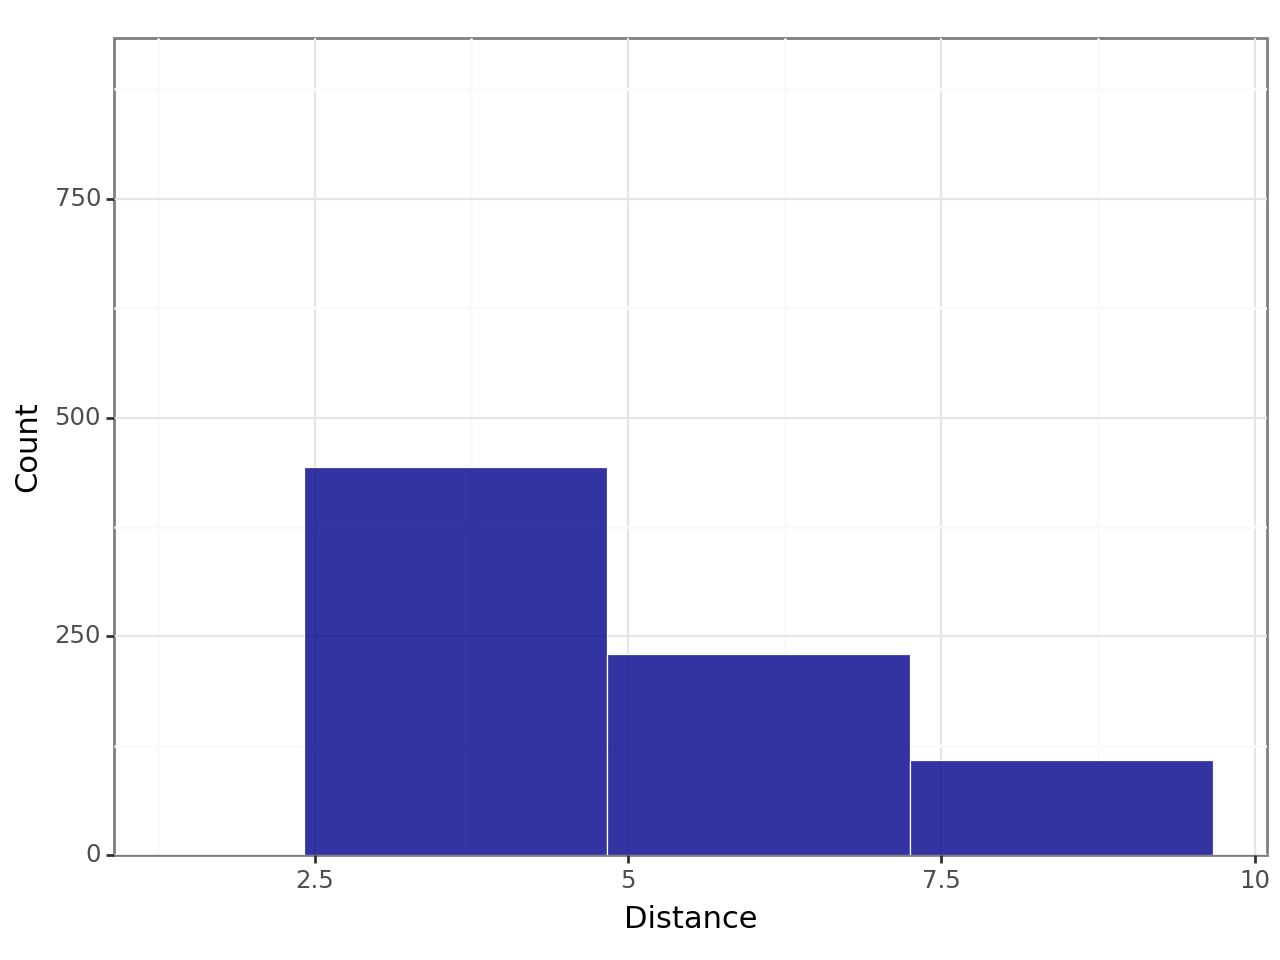

<Figure Size: (640 x 480)>

In [262]:
# Calculate range of 'rating_reviewcount' data
data_range_distance = merged_hotel_data_moscow['distance'].max() - merged_hotel_data_moscow['distance'].min()

# Calculate binwidth for 12 bins
binwidth = data_range_distance / 12

# distance from the center distribution
(
    ggplot(merged_hotel_data_moscow, aes(x="distance", y="..count.."))
    + geom_histogram(
        binwidth=binwidth,
        boundary=0,
        color="white",
        fill="darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Distance", y="Count")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 10))
    + scale_y_continuous(
        expand=(0.0, 0.0),
    )
    + theme_bw()
)

In [259]:
# Determine best number of bins using Sturges' Rule
num_bins_rating_reviewcount = int(1 + np.log2(len(merged_hotel_data_moscow['rating_reviewcount'])))
print(f"Optimal number of bins for 'rating_reviewcount': {num_bins_rating_reviewcount}")

Optimal number of bins for 'rating_reviewcount': 12


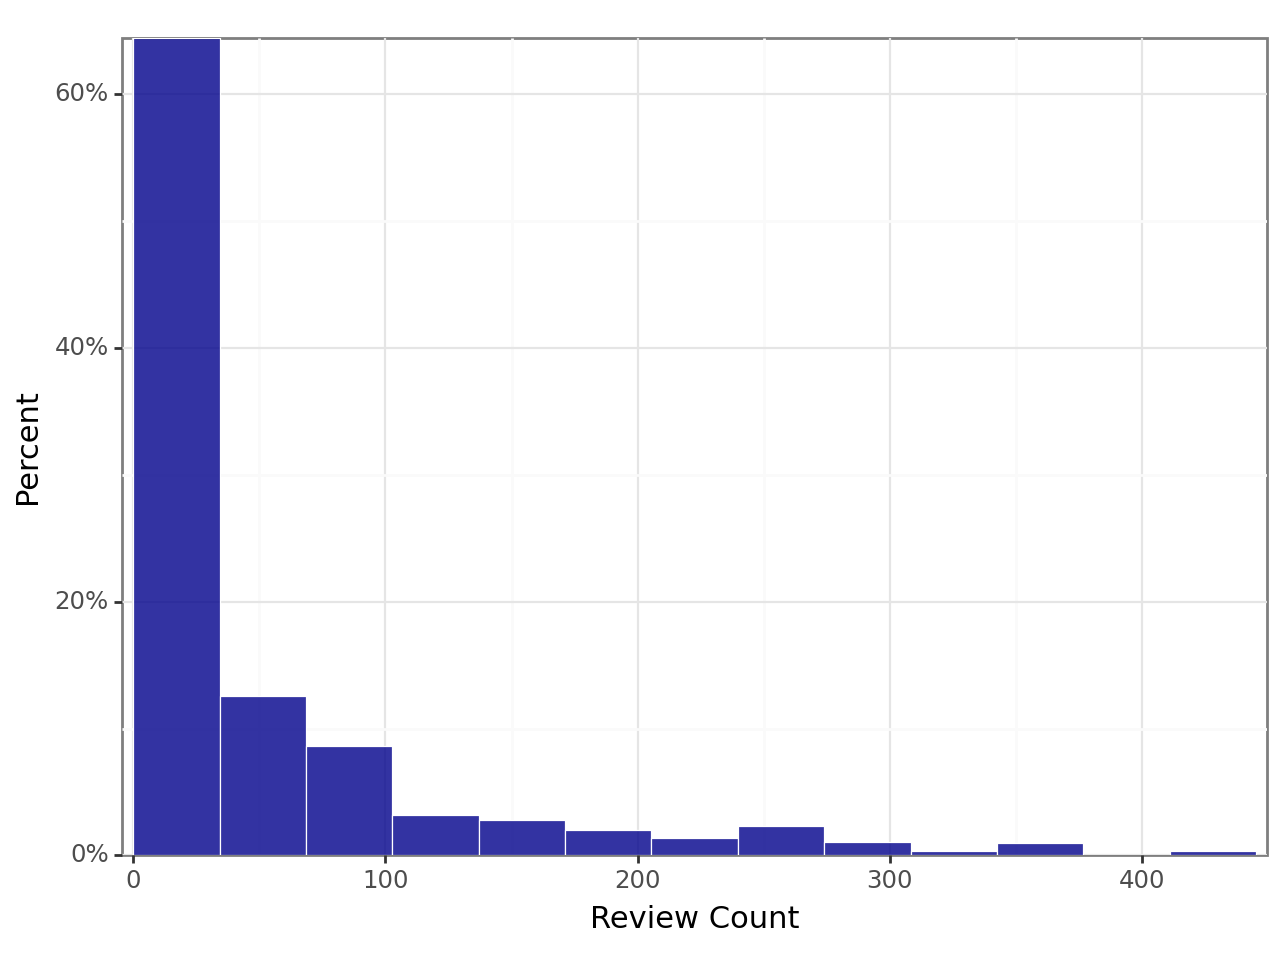

<Figure Size: (640 x 480)>

In [253]:
# Calculate range of 'rating_reviewcount' data
data_range = merged_hotel_data_moscow['rating_reviewcount'].max() - merged_hotel_data_moscow['rating_reviewcount'].min()

# Calculate binwidth for 12 bins
binwidth = data_range / 12

# Create the histogram
(
    ggplot(merged_hotel_data_moscow, aes(x="rating_reviewcount", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=binwidth,  # Set calculated binwidth
        boundary=0,
        color="white",
        fill="darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Review Count", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01))
    + scale_y_continuous(
        labels=percent_format(),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)

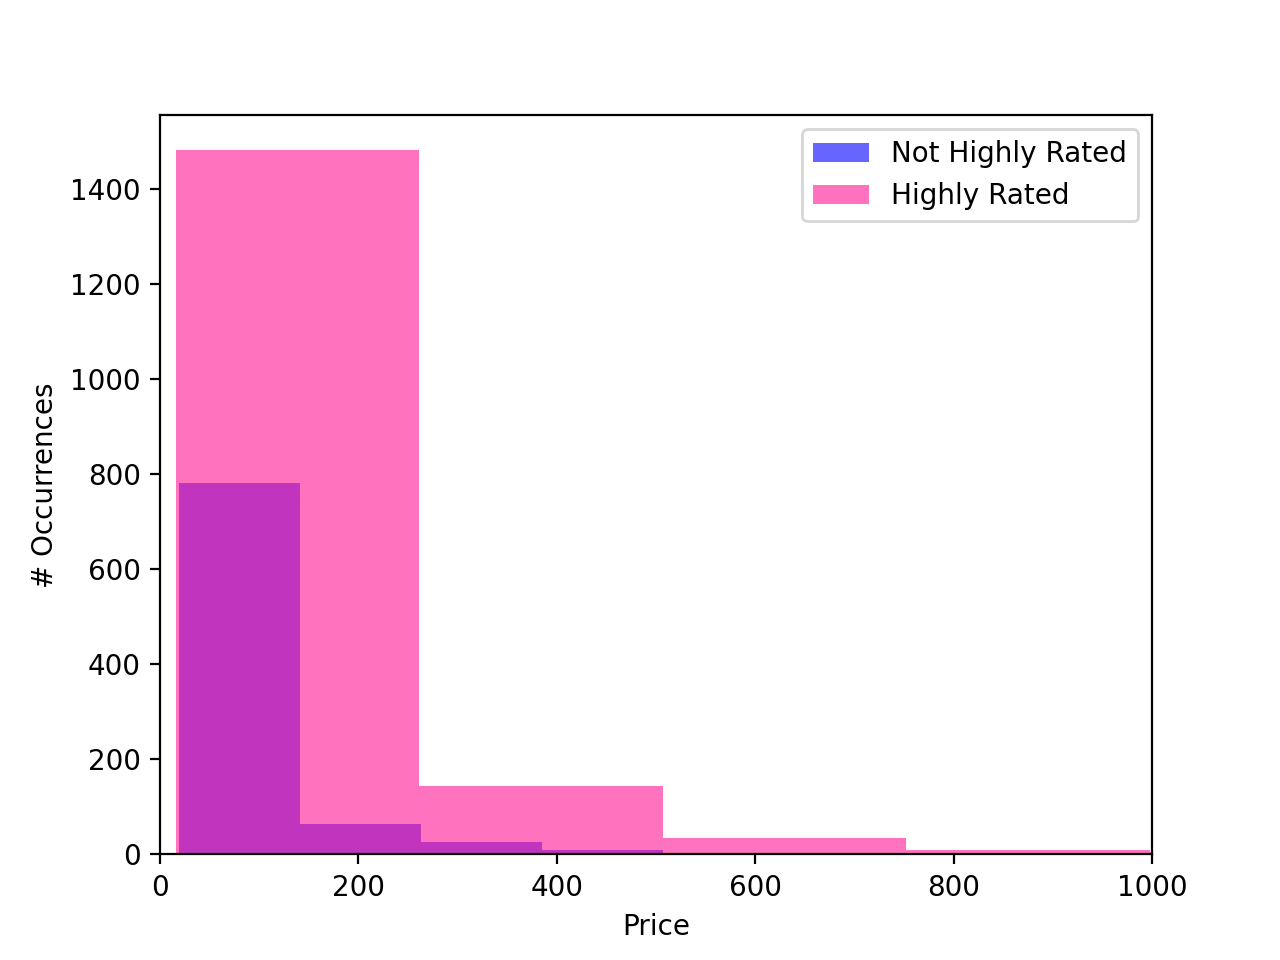

In [254]:
plt.hist(merged_hotel_data_moscow[merged_hotel_data_moscow["highly_rated"] == 0]["price"].reset_index(drop=True), alpha=0.6, label="Not Highly Rated", color="blue")
plt.hist(merged_hotel_data_moscow[merged_hotel_data_moscow["highly_rated"] == 1]["price"].reset_index(drop=True), alpha=0.6, label="Highly Rated", color="deeppink")

plt.xlabel("Price")
plt.ylabel("# Occurrences")
plt.legend()

# Set the upper limit of the x-axis to 1000
plt.xlim(0, 1000)

plt.show()


In [255]:
merged_hotel_data_moscow.loc[:, ["price", "highly_rated", "rating_reviewcount", "stars", "distance", "nnights"]].describe()

,price,highly_rated,rating_reviewcount,stars,distance,nnights
count,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000
mean,120.265004,0.655105,49.950896,3.235776,4.810171,1.344895
std,153.647841,0.475427,74.871778,0.956022,5.710563,0.957125
min,16.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,50.000000,0.000000,6.000000,3.000000,1.200000,1.000000
50%,73.000000,1.000000,17.000000,3.000000,2.200000,1.000000
75%,120.000000,1.000000,61.000000,4.000000,6.000000,1.000000
max,2471.000000,1.000000,412.000000,5.000000,29.000000,4.000000


In [268]:
reg1 = smf.ols(formula="price~highly_rated", data=merged_hotel_data_moscow).fit(cov_type="HC1")
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     112.7
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           8.57e-26
Time:                        17:07:59   Log-Likelihood:                -16520.
No. Observations:                2566   AIC:                         3.304e+04
Df Residuals:                    2564   BIC:                         3.306e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            83.5706      3.121     26.781      0.000      77.454      89.687
highly_rated[T.1]    56.0130      5.276     10.616      0.000      45.671      66.355
==============================================================================
Omnibus:                     2970.181   Durbin-Watson:                   1.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           379832.136
Skew:                           5.886   Prob(JB):                         0.00
Kurtosis:                      61.430   Cond. No.                         3.17
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [280]:
# Quartiles of the rating_reviewcount column

# Assuming merged_hotel_data_moscow is your DataFrame

# Calculate quartiles
Q1 = merged_hotel_data_moscow['distance'].quantile(0.25)
Q2 = merged_hotel_data_moscow['distance'].quantile(0.50)  # This is also the median
Q3 = merged_hotel_data_moscow['distance'].quantile(0.75)
Q95 = merged_hotel_data_moscow['distance'].quantile(0.95)
print(f"First Quartile (Q1): {Q1}")
print(f"Second Quartile (Q2, Median): {Q2}")
print(f"Third Quartile (Q3): {Q3}")
print(f"95th: {Q95}")

First Quartile (Q1): 1.2
Second Quartile (Q2, Median): 2.2
Third Quartile (Q3): 6.0
95th: 16.0


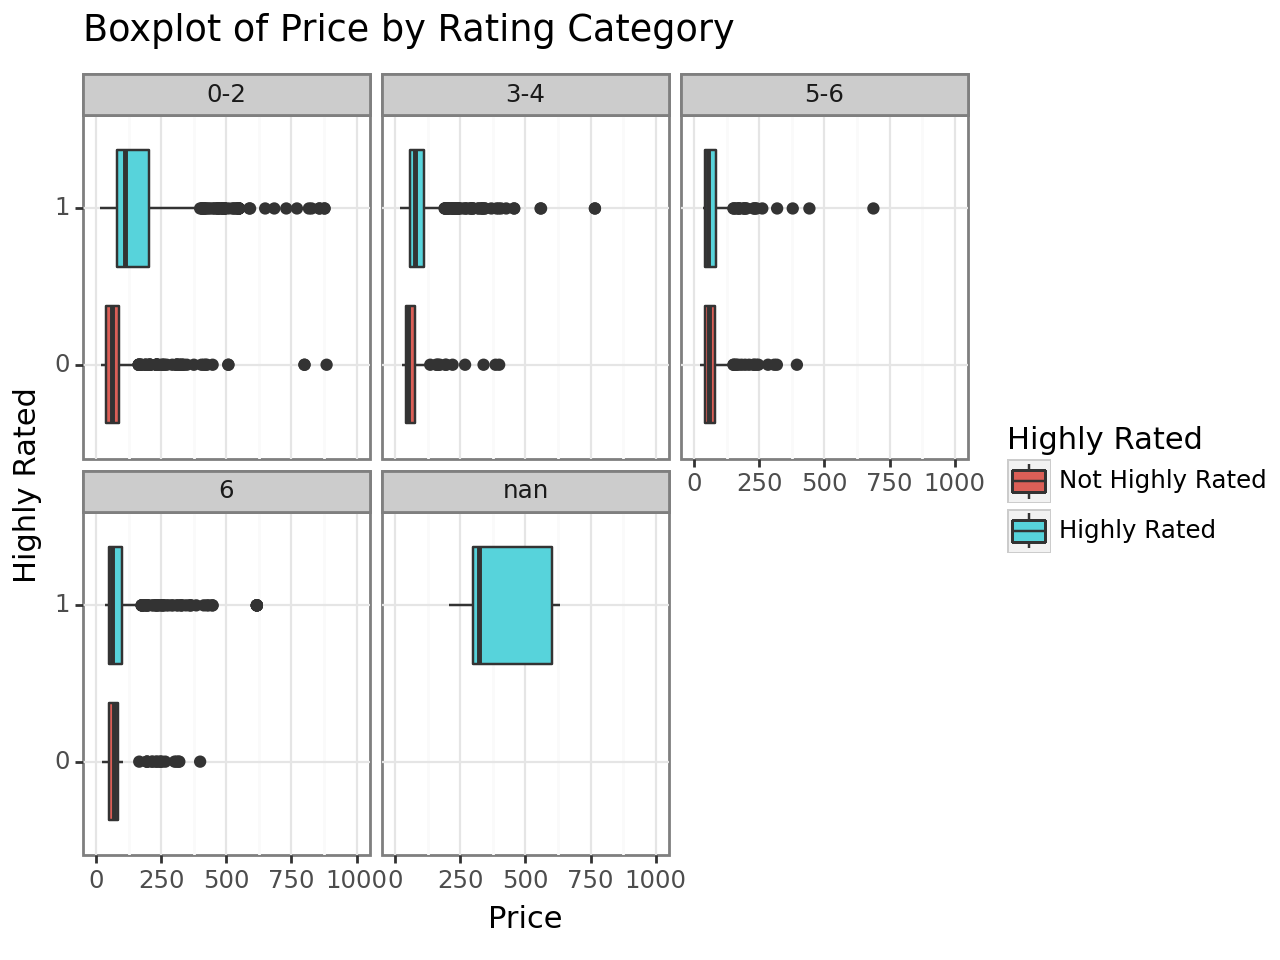

<Figure Size: (640 x 480)>

In [277]:
# Ensure 'highly_rated' is a categorical variable
merged_hotel_data_moscow['highly_rated'] = merged_hotel_data_moscow['highly_rated'].astype('category')

# Bin 'distance' and convert to categorical
merged_hotel_data_moscow['distance_category'] = pd.cut(merged_hotel_data_moscow['distance'], bins=[0, 2, 4, 6, np.inf], labels=['0-2', '3-4', '5-6', '6'])
merged_hotel_data_moscow['distance_category'] = merged_hotel_data_moscow['distance_category'].astype('category')

# Plot
(
    ggplot(data=merged_hotel_data_moscow) +
    aes(x="highly_rated", y="price", fill="highly_rated") +
    geom_boxplot() +
    coord_flip() +  # This swaps the x and y axes
    facet_wrap("~distance_category") +
    theme_bw() +
    scale_fill_discrete(labels=["Not Highly Rated", "Highly Rated"]) +
    labs(title="Boxplot of Price by Rating Category", x="Highly Rated", y="Price", fill="Highly Rated") +
    scale_y_continuous(limits=(0, 1000))  # Set limit on the y-axis, which is now displaying the 'price'
)


In [270]:
# Quartiles of the rating_reviewcount column

# Assuming merged_hotel_data_moscow is your DataFrame

# Calculate quartiles
Q1 = merged_hotel_data_moscow['rating_reviewcount'].quantile(0.25)
Q2 = merged_hotel_data_moscow['rating_reviewcount'].quantile(0.50)  # This is also the median
Q3 = merged_hotel_data_moscow['rating_reviewcount'].quantile(0.75)
Q99 = merged_hotel_data_moscow['rating_reviewcount'].quantile(0.99)
print(f"First Quartile (Q1): {Q1}")
print(f"Second Quartile (Q2, Median): {Q2}")
print(f"Third Quartile (Q3): {Q3}")
print(f"99th: {Q99}")

First Quartile (Q1): 6.0
Second Quartile (Q2, Median): 17.0
Third Quartile (Q3): 61.0
99th: 344.0


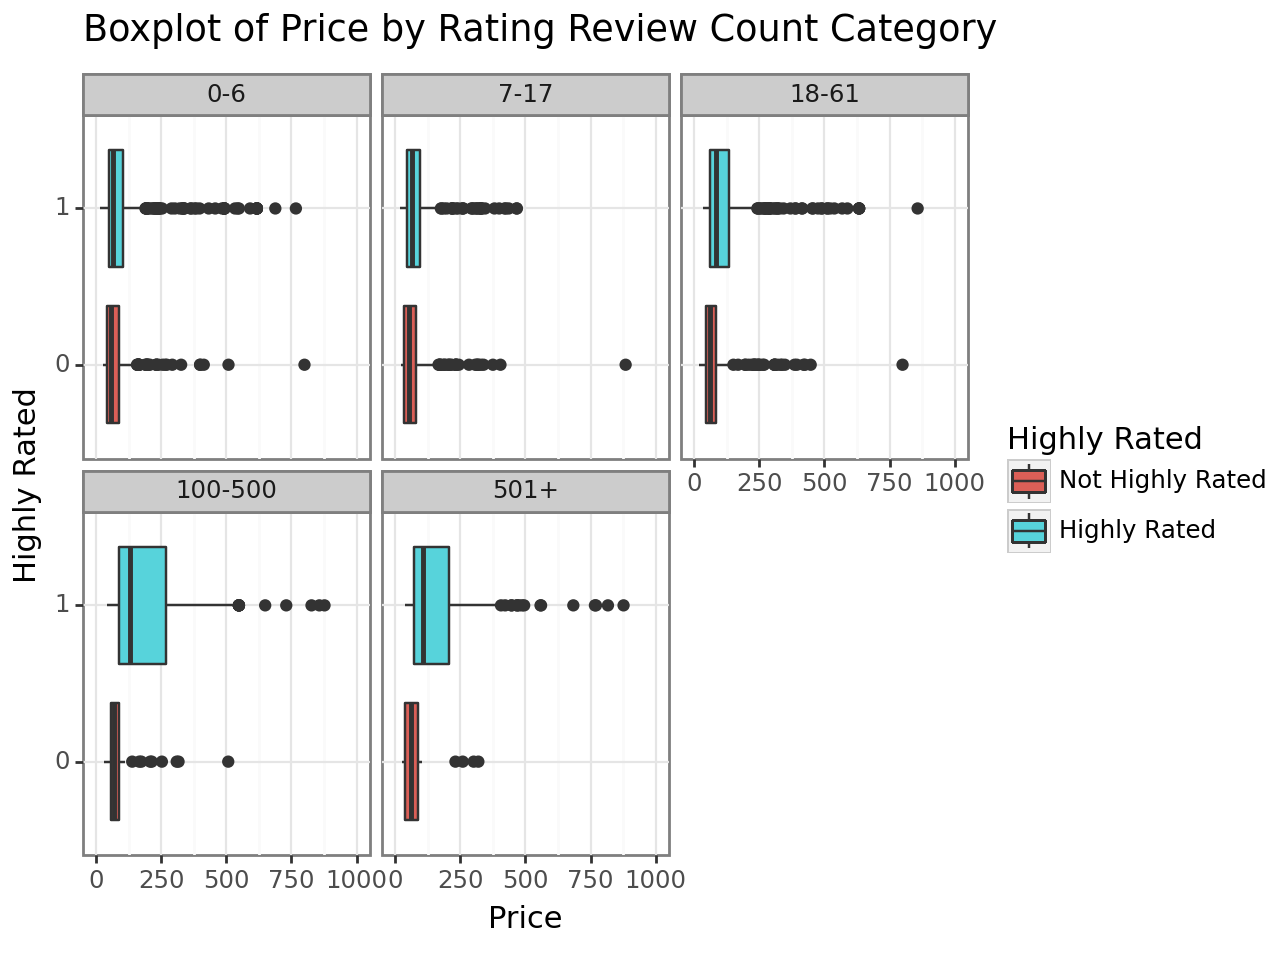

<Figure Size: (640 x 480)>

In [273]:
# Create bins for 'rating_reviewcount'
bins = [0, 6, 17, 61, 100, np.inf]  # Adjust bins as needed
labels = ['0-6', '7-17', '18-61', '100-500', '501+']
merged_hotel_data_moscow['rating_reviewcount_category'] = pd.cut(merged_hotel_data_moscow['rating_reviewcount'], bins=bins, labels=labels)

# Plot
(
    ggplot(data=merged_hotel_data_moscow) +
    aes(x="highly_rated", y="price", fill="highly_rated") +
    geom_boxplot() +
    coord_flip() +  # This swaps the x and y axes
    facet_wrap("~rating_reviewcount_category") +  # Use the binned category for faceting
    theme_bw() +
    scale_fill_discrete(labels=["Not Highly Rated", "Highly Rated"]) +
    labs(title="Boxplot of Price by Rating Review Count Category", x="Highly Rated", y="Price", fill="Highly Rated") +
    scale_y_continuous(limits=(0, 1000))  # Set limit on the y-axis, which is now displaying the 'price'
)